# Safety levels

NEN 8700 prescribes a number of safety levels. These safety levels are reliability indices a construction should fulfill. They are given in the next table:

| Safety level | Assessment level |
| CC3 | 3.3 |
| CC2 | 2.5 |
| CC1b | 1.8 |
| CC1a | 1.8 |


** Pile bearing capacity

The safety levels are applied to the bearing capacity of a pile.

We assume that there are 2 soil layers, the top layer consists of clay and the bottom layer conssists of sand. The surface level is at 0 m NAP.
The soil has the following characteristics    

| Parameter | Description |
| z | Depth at which the sand layer starts |
| q_clay | CPT resistance in clay layer|
| q_sand | CPT resistance in sand layer|
    
The Koppejan method is used to calculate the bearing capapcity. The pile has the following characteristics:

| Parameter | Description |
| D | Diameter of the pile|
| L | Length of the pile |

The bearing capacity *p* is calculated accorind to Koppejan as follows:

A = 1/4 * *pi* * D^2      
L_clay = min(L, z)
L_sand = max(0, L - z)

q_i = L > z ? q_sand : q_sand * ((z-L) / 0.7 * A) + q_clay * (1 - (z-L)/0.7 * A)
q_ii = q_i
q_iii = L_sand > 8 * A ? q_sand : q_sand * (L_sand/8*A)) + q_clay * (1 - L_sand/(8*A))
q_tip = 1/4 * q_i + 1/4 * q_ii + 1/2 * q_iii

p_tip = A * q_tip
p_shaft = *pi* * D * (q_clay * L_clay + q_sand * L_sand)

p = p_tip + p_shaft


In [1]:
import sys
import math

def get_bearing_capacity(z, q_clay, q_sand, D, L):
    A = 0.25 * math.pi * D * D      
    L_clay = min(L, z)
    L_sand = max(0, L - z)

    q_i = q_sand if L > z else q_sand * ((z-L) / 0.7 * A) + q_clay * (1 - (z-L)/0.7 * A)
    q_ii = q_i
    q_iii = q_sand if L_sand > 8 * A else q_sand * (L_sand/8*A) + q_clay * (1 - L_sand/(8*A))
    q_tip = 0.25 * q_i + 0.25 * q_ii + 0.5 * q_iii

    p_tip = A * q_tip
    p_shaft = math.pi * D * (q_clay * L_clay + q_sand * L_sand)

    p = p_tip + p_shaft
    
    return p
   

In [2]:
def get_unity_check(Load, z, q_clay, q_sand, D, L):
    p = get_bearing_capacity(z, q_clay, q_sand, D, L)
    UC = Load / p
    return UC

In [3]:
from probabilistic_library import SensitivityProject, DistributionType, SensitivityMethod

project = SensitivityProject()
project.model = get_unity_check

for var in project.variables:
    print(var.name)


Load
z
q_clay
q_sand
D
L


In [5]:
project.variables['D'].distribution = DistributionType.normal
project.variables['D'].mean = 0.2
project.variables['D'].deviation = 0.04
project.variables['D'].truncated = True
project.variables['D'].minimum = 0
project.variables['D'].maximum = 1

project.variables['L'].distribution = DistributionType.normal
project.variables['L'].mean = 12
project.variables['L'].deviation = 0.8

project.variables['z'].distribution = DistributionType.normal
project.variables['z'].mean = 10
project.variables['z'].deviation = 0.2

project.variables['q_sand'].distribution = DistributionType.log_normal
project.variables['q_sand'].mean = 500
project.variables['q_sand'].deviation = 50

project.variables['q_clay'].distribution = DistributionType.log_normal
project.variables['q_clay'].mean = 25000
project.variables['q_clay'].deviation = 400

project.variables['Load'].distribution = DistributionType.gumbel
project.variables['Load'].design_quantile = 0.95
project.variables['Load'].design_factor = 1
project.variables['Load'].variation = 0.1
project.variables['Load'].design_value = 100000

print('Load = ' + str(project.variables['Load'].mean) + ' +- ' + str(project.variables['Load'].deviation))

Load = 84275.86555480957 +- 8427.586555480957


Text(0.5, 1.0, 'crude_monte_carlo')

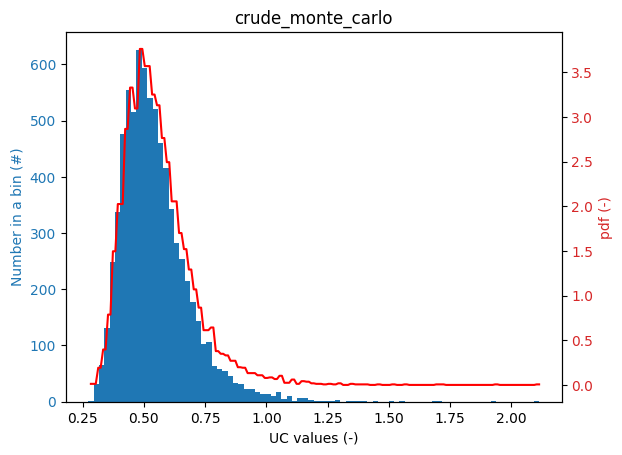

In [6]:
from probabilistic_library import StandardNormal

project.settings.sensitivity_method = SensitivityMethod.crude_monte_carlo
project.settings.maximum_samples = 10000

project.run()
uc = project.stochast

import matplotlib.pyplot as plt
import numpy as np

bin_start = [uc.histogram_values[ii].lower_bound for ii in range(0, len(uc.histogram_values))]
bin_end = [uc.histogram_values[ii].upper_bound for ii in range(0, len(uc.histogram_values))]
amount = [uc.histogram_values[ii].amount for ii in range(0, len(uc.histogram_values))]

pdf_grid = np.arange(min(bin_start), max(bin_end), 0.01)
pdf = [uc.get_pdf(val) for val in pdf_grid]

fig, ax1 = plt.subplots()
color = "tab:blue"
ax1.set_xlabel("UC values (-)")
ax1.set_ylabel("Number in a bin (#)", color=color)
ax1.bar(bin_start, amount, width=(np.array(bin_end)-np.array(bin_start)), label=var)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("pdf (-)", color=color)
ax2.plot(pdf_grid, pdf, "r", label="pdf")
ax2.tick_params(axis="y", labelcolor=color)
plt.title(project.settings.sensitivity_method)

** Connect to safety levels

To get the values at the safety levels, we calculate them usiing the quantile value. 

The value at the safety level gives an indication of failure. It also gives an impression how far oof the requested level. 

In [7]:
for sl in [1.8, 2.5, 3.3]:
    p = StandardNormal.get_p_from_u(sl)
    uc_sl = uc.get_quantile(p)
    print ('Safety level: ' + str(sl) + ' => UC = ' + str(uc_sl))

Safety level: 1.8 => UC = 0.8564465331922664
Safety level: 2.5 => UC = 1.0979817498206819
Safety level: 3.3 => UC = 1.692590544200054


** Conclusion

We see that only safety level CC1b passed the assessment test. CC3 is far off the required safety 

In [8]:
project.settings.maximum_samples = 100000
project.run()
uc_mc = project.stochast

print ('mc results (100000):')
for sl in [1.8, 2.5, 3.3]:
    p = StandardNormal.get_p_from_u(sl)
    uc_sl = uc_mc.get_quantile(p)
    print ('Safety level: ' + str(sl) + ' => UC = ' + str(uc_sl))

project.settings.sensitivity_method = SensitivityMethod.form
project.run()
uc_form = project.stochast

print('')
print ('form results:')
for sl in [1.8, 2.5, 3.3]:
    p = StandardNormal.get_p_from_u(sl)
    uc_sl = uc_form.get_quantile(p)
    print ('Safety level: ' + str(sl) + ' => UC = ' + str(uc_sl))

project.settings.sensitivity_method = SensitivityMethod.directional_sampling
project.settings.maximum_samples = 10000
for sl in [1.8, 2.5, 3.3]:
    p = StandardNormal.get_p_from_u(sl)
    project.settings.quantiles.append(p)
project.run()
uc_ds = project.stochast

print('')
print ('directional sampling results:')
for sl in [1.8, 2.5, 3.3]:
    p = StandardNormal.get_p_from_u(sl)
    uc_sl = uc_ds.get_quantile(p)
    print ('Safety level: ' + str(sl) + ' => UC = ' + str(uc_sl))



mc results (100000):
Safety level: 1.8 => UC = 0.8564465331922664
Safety level: 2.5 => UC = 1.0979817498206819
Safety level: 3.3 => UC = 1.692590544200054

form results:
Safety level: 1.8 => UC = 0.8486372475508219
Safety level: 2.5 => UC = 1.0785675207887286
Safety level: 3.3 => UC = 1.5679556733624995

directional sampling results:
Safety level: 1.8 => UC = 0.8589220410624954
Safety level: 2.5 => UC = 0.9082244423193354
Safety level: 3.3 => UC = 0.9645700437557241
